In [1]:
#libraries we need
import numpy as np 
import matplotlib.pyplot as plt
import load_mnist
import math
import time
import torch
from sklearn.utils import shuffle

In [2]:
#Training test plot curve code that was provided in assignment 1 to get the plots
#modified it to contain the time and number of epochs
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, time, epochs):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Number of Epochs:{epochs} | Training Time:{round(time)}sec |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    x = range(1, len(train_costs)+1)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)


In [3]:
#get the train and test data from the dataset
xtrain,ytrain,xtest,ytest = load_mnist.load_mnist()
#looking at the output
print("X Train shape", xtrain.shape)
print("Y Train shape", ytrain.shape)
print("X Test shape", xtest.shape)
print("Y Test shape", ytest.shape)

X Train shape (60000, 784)
Y Train shape (60000, 10)
X Test shape (10000, 784)
Y Test shape (10000, 10)


In [140]:
#converting to Tensors for easy PyTorch implementation
xtrain = torch.Tensor(xtrain).to("cpu")
ytrain = torch.Tensor(ytrain).to("cpu")
xtest = torch.Tensor(xtest).to("cpu")
ytest = torch.Tensor(ytest).to("cpu")

In [148]:
#first we want to put our data in a pytorch dataset so we can mini batch and enumerate through it later more easily
train_dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
test_dataset = torch.utils.data.TensorDataset(xtest, ytest)

In [142]:
#calculating the accuracy given outputs not softmaxed and labels one hot encoding.
def calculate_accuracy(outputs, labels):
    #don't need to softmax because the max value will be the max softmax we just pull the index to get the digit prediction 
    _, output_index = torch.max(outputs,1)
    #get the index/ digit of the label
    _, label_index = torch.max(labels, 1)
    # return the number of correct matches and divide by the size to get accuracy
    return (output_index == label_index).sum().item()/labels.size(0)

In [158]:
#training loop function'
def training_loop(train_loader, test_loader, num_epochs, model, loss_function, optimizer):
    #arrays for our plots
    training_loss = []
    training_accuracy = []
    test_loss = []
    test_accuracy =[]
    #Setting up the training loop
    print("Starting the Training Loop")
    for epoch in range(num_epochs):
        #keep the loss and accuracies after each mini batch
        batch_loss = []
        batch_accuracy = []
        #loop through a mini-batch on the same train loadear
        for batch_index, (data, label) in enumerate(train_loader):
            # Forward pass
            outputs = model(data)
            #evaluate the loss
            loss = loss_function(outputs, label)
            #append the loss to the batch loss
            batch_loss.append(loss.item())
            #calculate the accuracy based on the outputs (not softmaxed) and labels. Do outputs.data so we don't pass gradient info
            batch_accuracy.append(calculate_accuracy(outputs.data, label))

            # Backward pass setting gradients to zero
            optimizer.zero_grad()
            #calcualting gradients
            loss.backward()
            #updating parameters
            optimizer.step()

        #add to the training epoch accuracies and losses
        training_accuracy.append(np.average(batch_accuracy))
        training_loss.append(np.average(batch_loss))
        #get the test loss and accuracy
        #change mode
        model.eval()
        #so we don't accidentally change anything
        with torch.no_grad():
            #get the "batch" of the test data which is all of it
            for batch_index, (data, label) in enumerate(test_loader):
                #get our test predicitons
                test_predictions = model(data)
                #test loss and move to cpu so I can plot
                loss = loss_function(test_predictions, label).to("cpu")
                #append statistics
                test_loss.append(loss)
                test_accuracy.append(calculate_accuracy(test_predictions.data, label))
        #back to training mode
        model.train()
        #printing
        print(f"Epoch: {epoch} done. Test loss {test_loss[epoch]}. Test accuracy {test_accuracy[epoch]}")
    return training_loss, training_accuracy, test_loss, test_accuracy

## Exercise 1
Want to make the exact same NN that I did in assignment 1 and the line below is the code I used for the deep NN  
```deep_model = numpyNN(k = 2, activation_function="ReLU", mini_batch=128, epochs= 150, iterations = 300000, alpha = 0.01)```  
And the rest of the init function for my class looked like  
```def __init__(self, k = 2, d = 50, d_i = 784, d_o = 10, activation_function = "ReLU", alpha = 0.05, mini_batch = 100, iterations = 100000, x_train = xtrain, y_train=ytrain, x_test = xtest, y_test = ytest, epochs = 500):```  
So using Pytorch I want to create a deep fully connected NN with 2 hidden layers, 50 nodes per hidden layer, 784 is the input, 10 is the output, activation function is ReLU, a mini batch of 128, 150 epochs, and learning rate of 0.01. The epochs parameter ended training before iterations in this context and size we want to compare epochs we will focus on this instead of iterations from now on.

In [159]:
# Here we make a neural network that is identical to the one in assignment 1
# so it will be a deep NN of 2 hidden layers, 50 nodes per layer
class Assignment1NN(torch.nn.Module):
    def __init__(self, input_size = 784, hidden_size = 50, output_size = 10):
        super().__init__()
        #First hiddent layer
        self.hidden1 = torch.nn.Linear(input_size, hidden_size)
        #ReLU activation function
        self.relu1 = torch.nn.ReLU()
        #second hidder layer
        self.hidden2 = torch.nn.Linear(hidden_size, hidden_size)
        #ReLU activation function
        self.relu2 = torch.nn.ReLU()
        #output layer
        self.output = torch.nn.Linear(hidden_size, output_size)
    #forward pass through the network
    def forward(self, x):
        #pass through first hidden layer
        x = self.hidden1(x)
        #activation function
        x = self.relu1(x)
        #hidden layer 2
        x = self.hidden2(x)
        #activation function
        x = self.relu2(x)
        #pass through the output layer
        x = self.output(x)
        return x

# setting the hyperparameters for exercise 1
input_size_1 = 784
num_classes_1 = 10
learning_rate_1 = 0.01
batch_size_1 = 128
num_epochs_1 = 150

#Making a dataloader for this specific NN which is a wrapper around the Dataset for easy use
train_loader_1 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_1, shuffle=True)
#make the batch size for the test DataLoader the size of the dataset for evaluation.
test_loader_1 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = ytest.shape[0], shuffle=True)

#This is the Neural Network model
model_1 = Assignment1NN(input_size = input_size_1, hidden_size = 50, output_size = num_classes_1).to("cpu")
#Our loss function will be cross entropy since we are getting a probability distribution
loss_1 = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr= learning_rate_1)
start_1 = time.time()
training_loss_1, training_accuracy_1, test_loss_1, test_accuracy_1 = training_loop(train_loader_1, test_loader_1, 
num_epochs_1, model_1, loss_1,optimizer_1)

end_1 = time.time()
total_time = end_1 - start_1

Starting the Training Loop
Epoch: 0 done. Test loss 1.8495723009109497. Test accuracy 0.496
Epoch: 1 done. Test loss 0.8392381072044373. Test accuracy 0.782
Epoch: 2 done. Test loss 0.5454843640327454. Test accuracy 0.8517
Epoch: 3 done. Test loss 0.44818270206451416. Test accuracy 0.8734
Epoch: 4 done. Test loss 0.3996987044811249. Test accuracy 0.8854
Epoch: 5 done. Test loss 0.36990395188331604. Test accuracy 0.8944
Epoch: 6 done. Test loss 0.3496186137199402. Test accuracy 0.8985
Epoch: 7 done. Test loss 0.3347225487232208. Test accuracy 0.9016
Epoch: 8 done. Test loss 0.31991416215896606. Test accuracy 0.9066
Epoch: 9 done. Test loss 0.30768030881881714. Test accuracy 0.9095
Epoch: 10 done. Test loss 0.2978443503379822. Test accuracy 0.9139
Epoch: 11 done. Test loss 0.2908955216407776. Test accuracy 0.9171
Epoch: 12 done. Test loss 0.2802082896232605. Test accuracy 0.9195
Epoch: 13 done. Test loss 0.2723838984966278. Test accuracy 0.923
Epoch: 14 done. Test loss 0.2687005698680877

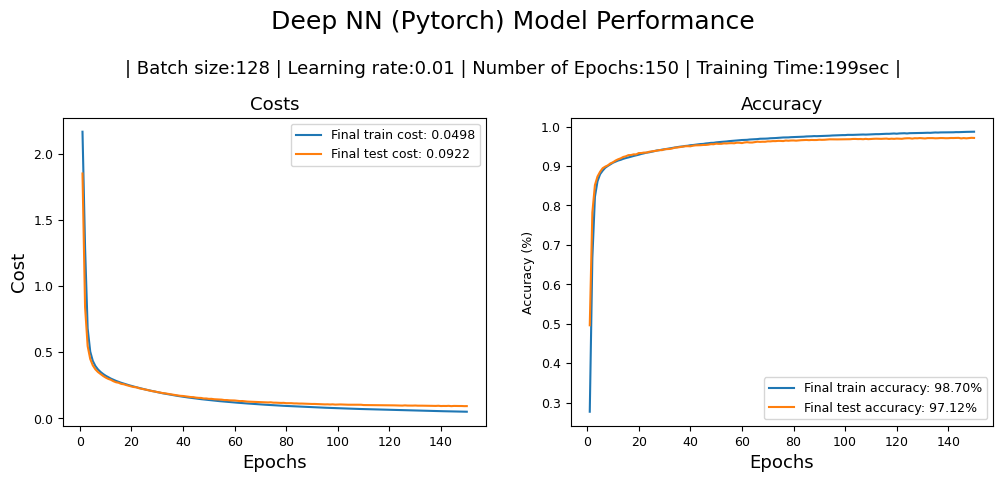

In [160]:
training_curve_plot("Deep NN (Pytorch) Model Performance", training_loss_1, test_loss_1, training_accuracy_1, test_accuracy_1, 
128, 0.01, total_time, num_epochs_1)

In [161]:
sum_1 = 0
for param in model_1.parameters():
    sum_1 += param.numel()
print(sum_1)

42310


## Exercise 2  
Implement a convolutional neural network

In [162]:
#will use local computer GPU to speed up training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
print(torch.cuda.is_available())  # True if CUDA is available
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.current_device())  # Current GPU index
print(torch.cuda.get_device_name(0))  # Name of the GPU

Using device: cuda
True
1
0
NVIDIA GeForce RTX 4050 Laptop GPU


In [163]:
# since we are now working with a convolutional neural network we need to reshape the data to be a 2D array for x
# y stays the same 
#reshape to N, Channels, height, width
xtrain_cnn = xtrain.reshape(60000, 1,28,28).to(device)
xtest_cnn = xtest.reshape(10000, 1,28,28).to(device)
ytrain_cnn = ytrain.to(device)
ytest_cnn = ytest.to(device)
#make our datasets so we can make data loaders
train_dataset_cnn = torch.utils.data.TensorDataset(xtrain_cnn, ytrain_cnn)
test_dataset_cnn = torch.utils.data.TensorDataset(xtest_cnn, ytest_cnn)

In [164]:
#make the CNN for exercise 2 according to the specifications in the assignment
class Exercise2CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #1 input channel, 8 output channels, kernel size 3, stride 1, padding 1
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #non linearity
        self.relu1 = torch.nn.ReLU()
        #first pooling layer with kernel size 2, stride 2 reduces image to (8,14,14)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        #8 input channels, 16 output channels, kernel size 3, stride 1 padding 1
        self.conv2 = torch.nn.Conv2d(in_channels= 8,out_channels= 16 , kernel_size= 3, stride= 1, padding= 1)
        #non linearity
        self.relu2 = torch.nn.ReLU()
        #second pooling layer with kernel size 2, stride 2 reduces image to (16,7,7)
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 16 inputs, 32 outputs, kernel size 3, stride 1, padding 1
        self.conv3 = torch.nn.Conv2d(in_channels= 16,out_channels= 32 , kernel_size= 3, stride= 1, padding= 1)
        #non linearity
        self.relu3 = torch.nn.ReLU()
        #output netwrok we have 32 channels and an image that is (7,7)
        self.output = torch.nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        #pass through the first convolution and relu and pooling layers
        x = self.pool1(self.relu1(self.conv1(x)))
        #pass through the second convolution and relu and pooling layers
        x = self.pool2(self.relu2(self.conv2(x)))
        #pass through the final convolution and relu
        x = self.relu3(self.conv3(x))
        #flatten all dimensions except batch dimension which is dimension 0 so we start at 1
        x = torch.flatten(x, 1)
        #pass through our output layer
        x = self.output(x)
        return x

#want to set some hyperparameters 
learning_rate_2 = 0.01
batch_size_2 = 128
num_epochs_2 = 100

#Making a dataloader for this specific CNN which is a wrapper around the Dataset for easy use
train_loader_cnn = torch.utils.data.DataLoader(dataset=train_dataset_cnn, batch_size=batch_size_1, shuffle=True)
#make the batch size for the test DataLoader the size of the dataset for evaluation.
test_loader_cnn = torch.utils.data.DataLoader(dataset=test_dataset_cnn, batch_size = ytest.shape[0], shuffle=True)

#Make the CNN neural netowrk model
model_2 = Exercise2CNN().to(device)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_2 = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations since we will change this later
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr= learning_rate_2)

#find the start time
start_2 = time.time()

#run the training loop
training_loss_2, training_accuracy_2, test_loss_2, test_accuracy_2 = training_loop(train_loader_cnn, test_loader_cnn, 
num_epochs_2, model_2, loss_2, optimizer_2)

#end time and get the total time
end_2 = time.time()
total_time = end_2 - start_2

Starting the Training Loop
Epoch: 0 done. Test loss 2.2761473655700684. Test accuracy 0.1731
Epoch: 1 done. Test loss 0.6528091430664062. Test accuracy 0.7962
Epoch: 2 done. Test loss 0.35490116477012634. Test accuracy 0.8976
Epoch: 3 done. Test loss 0.3045685887336731. Test accuracy 0.9101
Epoch: 4 done. Test loss 0.2443363517522812. Test accuracy 0.9262
Epoch: 5 done. Test loss 0.18291504681110382. Test accuracy 0.9452
Epoch: 6 done. Test loss 0.15196703374385834. Test accuracy 0.9548
Epoch: 7 done. Test loss 0.13770146667957306. Test accuracy 0.9596
Epoch: 8 done. Test loss 0.10962840169668198. Test accuracy 0.9675
Epoch: 9 done. Test loss 0.10919030755758286. Test accuracy 0.9686
Epoch: 10 done. Test loss 0.10740622133016586. Test accuracy 0.9665
Epoch: 11 done. Test loss 0.08642216771841049. Test accuracy 0.9743
Epoch: 12 done. Test loss 0.07746364921331406. Test accuracy 0.976
Epoch: 13 done. Test loss 0.08267316222190857. Test accuracy 0.9748
Epoch: 14 done. Test loss 0.07814582

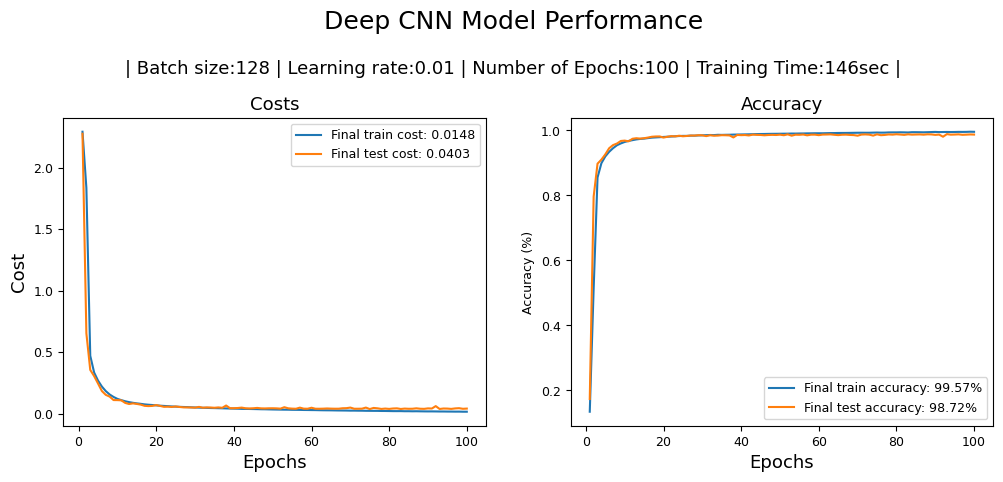

In [165]:
training_curve_plot("Deep CNN Model Performance", training_loss_2, test_loss_2, training_accuracy_2, test_accuracy_2, 
batch_size_2, learning_rate_2, total_time, num_epochs_2)

In [166]:
sum_2 = 0
for param in model_2.parameters():
    sum_2 += param.numel()
print(sum_2)

21578


## Exercise 3

In [167]:
#make the CNN for exercise 3 according to the specifications in the assignment
#which is almost identical to exercise 2
class Exercise3CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #1 input channel, 8 output channels, kernel size 3, stride 1, padding 1
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #non linearity
        self.relu1 = torch.nn.ReLU()
        #first pooling layer with kernel size 2, stride 2 reduces image to (8,14,14)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        #8 input channels, 16 output channels, kernel size 3, stride 1 padding 1
        self.conv2 = torch.nn.Conv2d(in_channels= 8,out_channels= 16 , kernel_size= 3, stride= 1, padding= 1)
        #non linearity
        self.relu2 = torch.nn.ReLU()
        #second pooling layer with kernel size 2, stride 2 reduces image to (16,7,7)
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 16 inputs, 32 outputs, kernel size 3, stride 1, padding 1
        self.conv3 = torch.nn.Conv2d(in_channels= 16,out_channels= 32 , kernel_size= 3, stride= 1, padding= 1)
        #non linearity
        self.relu3 = torch.nn.ReLU()
        #output netwrok we have 32 channels and an image that is (7,7)
        self.output = torch.nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        #pass through the first convolution and relu and pooling layers
        x = self.relu1(self.pool1(self.conv1(x)))
        #pass through the second convolution and relu and pooling layers
        x = self.relu2(self.pool2(self.conv2(x)))
        #pass through the final convolution and relu
        x = self.relu3(self.conv3(x))
        #flatten all dimensions except batch dimension which is dimension 0 so we start at 1
        x = torch.flatten(x, 1)
        #pass through our output layer
        x = self.output(x)
        return x

#want to set some hyperparameters 
learning_rate_3 = 0.01
batch_size_3 = 128
num_epochs_3 = 100

#Make the CNN neural netowrk model
model_3 = Exercise3CNN().to(device)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_3 = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations since we will change this later
optimizer_3 = torch.optim.SGD(model_3.parameters(), lr= learning_rate_3)

#find the start time
start_3 = time.time()

#run the training loop
training_loss_3, training_accuracy_3, test_loss_3, test_accuracy_3 = training_loop(train_loader_cnn, test_loader_cnn, 
num_epochs_3, model_3, loss_3, optimizer_3)

#end time and get the total time
end_3 = time.time()
total_time = end_3 - start_3

Starting the Training Loop
Epoch: 0 done. Test loss 2.135002613067627. Test accuracy 0.5856
Epoch: 1 done. Test loss 0.4088817536830902. Test accuracy 0.8733
Epoch: 2 done. Test loss 0.2851916551589966. Test accuracy 0.9121
Epoch: 3 done. Test loss 0.22035107016563416. Test accuracy 0.9357
Epoch: 4 done. Test loss 0.18215057253837585. Test accuracy 0.9448
Epoch: 5 done. Test loss 0.1459035575389862. Test accuracy 0.9581
Epoch: 6 done. Test loss 0.1271202564239502. Test accuracy 0.9624
Epoch: 7 done. Test loss 0.10951867699623108. Test accuracy 0.9663
Epoch: 8 done. Test loss 0.09985119104385376. Test accuracy 0.9701
Epoch: 9 done. Test loss 0.09115103632211685. Test accuracy 0.9706
Epoch: 10 done. Test loss 0.08040173351764679. Test accuracy 0.9733
Epoch: 11 done. Test loss 0.08073922991752625. Test accuracy 0.9745
Epoch: 12 done. Test loss 0.07038947939872742. Test accuracy 0.9765
Epoch: 13 done. Test loss 0.06736753135919571. Test accuracy 0.9777
Epoch: 14 done. Test loss 0.064568653

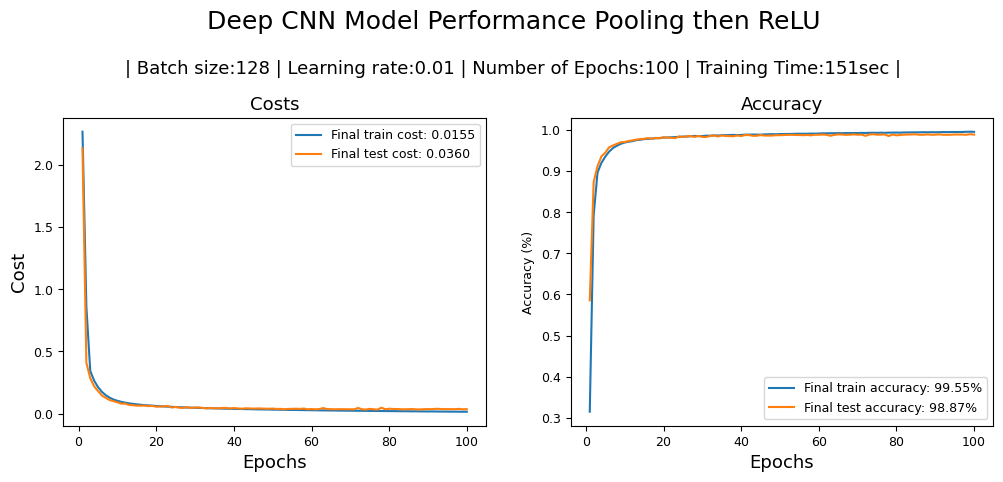

In [168]:
training_curve_plot("Deep CNN Model Performance Pooling then ReLU", training_loss_3, test_loss_3, training_accuracy_3, test_accuracy_3, 
batch_size_3, learning_rate_3, total_time, num_epochs_3)

In [169]:
#make the CNN for exercise 3b according to the specifications in the assignment
#which is almost identical to exercise 2 but we use tanh
class Exercise3bCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #1 input channel, 8 output channels, kernel size 3, stride 1, padding 1
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #non linearity
        self.tanh1 = torch.nn.Tanh()
        #first pooling layer with kernel size 2, stride 2 reduces image to (8,14,14)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        #8 input channels, 16 output channels, kernel size 3, stride 1 padding 1
        self.conv2 = torch.nn.Conv2d(in_channels= 8,out_channels= 16 , kernel_size= 3, stride= 1, padding= 1)
        #non linearity
        self.tanh2 = torch.nn.Tanh()
        #second pooling layer with kernel size 2, stride 2 reduces image to (16,7,7)
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 16 inputs, 32 outputs, kernel size 3, stride 1, padding 1
        self.conv3 = torch.nn.Conv2d(in_channels= 16,out_channels= 32 , kernel_size= 3, stride= 1, padding= 1)
        #non linearity
        self.tanh3 = torch.nn.Tanh()
        #output netwrok we have 32 channels and an image that is (7,7)
        self.output = torch.nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        #pass through the first convolution and relu and pooling layers
        x = self.tanh1(self.pool1(self.conv1(x)))
        #pass through the second convolution and relu and pooling layers
        x = self.tanh2(self.pool2(self.conv2(x)))
        #pass through the final convolution and relu
        x = self.tanh3(self.conv3(x))
        #flatten all dimensions except batch dimension which is dimension 0 so we start at 1
        x = torch.flatten(x, 1)
        #pass through our output layer
        x = self.output(x)
        return x

#want to set some hyperparameters 
learning_rate_3b = 0.01
batch_size_3b = 128
num_epochs_3b = 100

#Make the CNN neural netowrk model
model_3b = Exercise3bCNN().to(device)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_3b = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations since we will change this later
optimizer_3b = torch.optim.SGD(model_3b.parameters(), lr= learning_rate_3b)

#find the start time
start_3b = time.time()

#run the training loop
training_loss_3b, training_accuracy_3b, test_loss_3b, test_accuracy_3b = training_loop(train_loader_cnn, test_loader_cnn, 
num_epochs_3b, model_3b, loss_3b, optimizer_3b)

#end time and get the total time
end_3b = time.time()
total_time = end_3b - start_3b

Starting the Training Loop
Epoch: 0 done. Test loss 0.6915682554244995. Test accuracy 0.8193
Epoch: 1 done. Test loss 0.43374475836753845. Test accuracy 0.8752
Epoch: 2 done. Test loss 0.36151087284088135. Test accuracy 0.8937
Epoch: 3 done. Test loss 0.31907007098197937. Test accuracy 0.9066
Epoch: 4 done. Test loss 0.2903488874435425. Test accuracy 0.9148
Epoch: 5 done. Test loss 0.2668808400630951. Test accuracy 0.9233
Epoch: 6 done. Test loss 0.24706198275089264. Test accuracy 0.9257
Epoch: 7 done. Test loss 0.23008890450000763. Test accuracy 0.9328
Epoch: 8 done. Test loss 0.21353061497211456. Test accuracy 0.9383
Epoch: 9 done. Test loss 0.1986626535654068. Test accuracy 0.9421
Epoch: 10 done. Test loss 0.1851104497909546. Test accuracy 0.9457
Epoch: 11 done. Test loss 0.1729007065296173. Test accuracy 0.9481
Epoch: 12 done. Test loss 0.16176731884479523. Test accuracy 0.9513
Epoch: 13 done. Test loss 0.1500728726387024. Test accuracy 0.9575
Epoch: 14 done. Test loss 0.1403680592

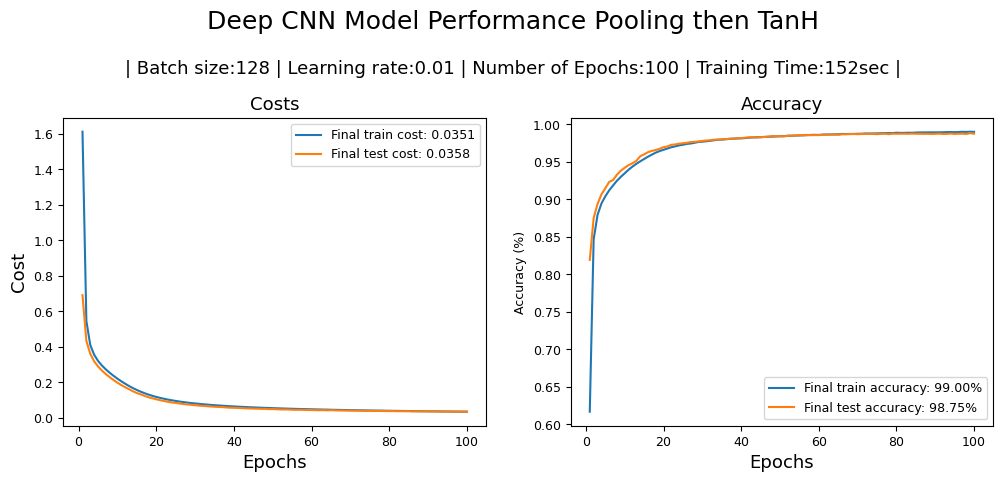

In [170]:
training_curve_plot("Deep CNN Model Performance Pooling then TanH", training_loss_3b, test_loss_3b, training_accuracy_3b, test_accuracy_3b, 
batch_size_3b, learning_rate_3b, total_time, num_epochs_3b)

## Exercise 4

In [171]:
#want to set some hyperparameters 
learning_rate_4 = 0.001
batch_size_4 = 128
num_epochs_4 = 100

#Make the CNN neural netowrk model
model_4 = Exercise2CNN().to(device)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_4 = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations since we will change this later
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr= learning_rate_4)

#find the start time
start_4 = time.time()

#run the training loop
training_loss_4, training_accuracy_4, test_loss_4, test_accuracy_4 = training_loop(train_loader_cnn, test_loader_cnn, 
num_epochs_4, model_4, loss_4, optimizer_4)

#end time and get the total time
end_4 = time.time()
total_time = end_4 - start_4

Starting the Training Loop
Epoch: 0 done. Test loss 0.11415182799100876. Test accuracy 0.9655
Epoch: 1 done. Test loss 0.06324738264083862. Test accuracy 0.9795
Epoch: 2 done. Test loss 0.05540793389081955. Test accuracy 0.9824
Epoch: 3 done. Test loss 0.0557495579123497. Test accuracy 0.9824
Epoch: 4 done. Test loss 0.03957729414105415. Test accuracy 0.9871
Epoch: 5 done. Test loss 0.03793296590447426. Test accuracy 0.9871
Epoch: 6 done. Test loss 0.03407381474971771. Test accuracy 0.9892
Epoch: 7 done. Test loss 0.033766601234674454. Test accuracy 0.9879
Epoch: 8 done. Test loss 0.0323340930044651. Test accuracy 0.9891
Epoch: 9 done. Test loss 0.02946530468761921. Test accuracy 0.9895
Epoch: 10 done. Test loss 0.03202684223651886. Test accuracy 0.9893
Epoch: 11 done. Test loss 0.0265875905752182. Test accuracy 0.9916
Epoch: 12 done. Test loss 0.029352543875575066. Test accuracy 0.9903
Epoch: 13 done. Test loss 0.032930053770542145. Test accuracy 0.9896
Epoch: 14 done. Test loss 0.034

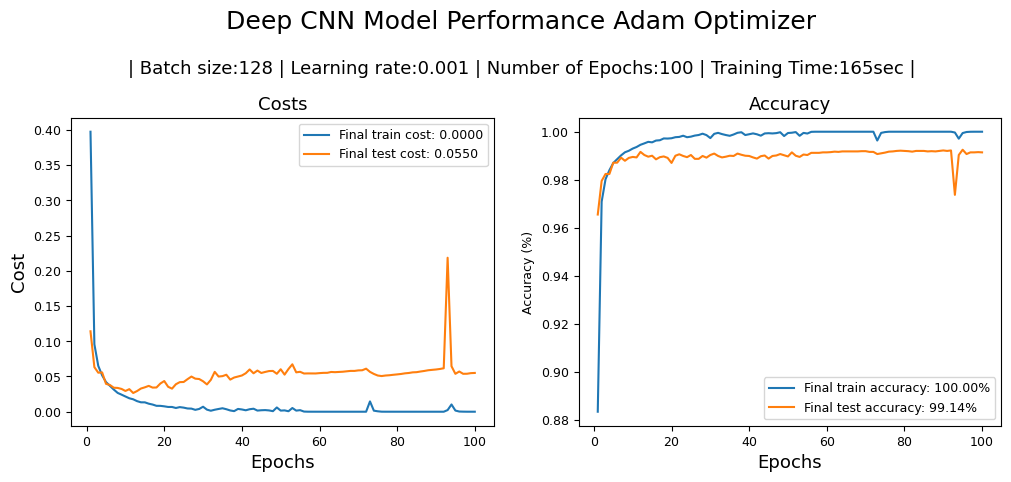

In [172]:
training_curve_plot("Deep CNN Model Performance Adam Optimizer", training_loss_4, test_loss_4, training_accuracy_4, test_accuracy_4, 
batch_size_4, learning_rate_4, total_time, num_epochs_4)

## Exercise 5
### Adding residual layers

In [179]:
#make the CNN residual network for exercise 5 according to the specifications in the assignment

#resdiual architecture for the 8 channels to 8 channels
class FirstKernelResidual(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #mimicks the first convolution but here we will just go from 8 inputs to 8 outputs
        self.conv = torch.nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #here are the relu and pooling layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        #modeling the books residual connection from section 11.2 figure 11.5b 
        # pass it through ReLU
        temp = self.relu(x)
        #then we pass it through our convolutional layer where we relu then pool
        temp = self.conv(temp)
        #add in our residual connection
        x = x + temp
        return x

#residual architecture for the 16 channels to 16 channels
class SecondKernelResidual(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #mimicks the first convolution but here we will just go from 8 inputs to 8 outputs
        self.conv = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        #here are the relu and pooling layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        #modeling the books residual connection from section 11.2 figure 11.5b 
        #pass through relu
        temp = self.relu(x)
        #then we pass it through our convolutional layer where we relu then pool
        temp = self.conv(temp)
        #add in our residual connection
        x = x + temp
        return x

#residual connections for 32 channels to 32 channels
class ThirdKernelResidual(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #mimicks the first convolution but here we will just go from 8 inputs to 8 outputs
        self.conv = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #here are the relu and pooling layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        #modeling the books residual connection from section 11.2 figure 11.5b 
        #we pass it through ReLU
        temp = self.relu(x)
        #then we pass it through our convolutional layer where we relu then pool
        temp = self.conv(temp)
        #add in our residual connection
        x = x + temp
        return x


class Exercise5CNN(torch.nn.Module):
    def __init__(self, first = 3,second = 3, third = 3):
        super().__init__()
        #1 input channel, 8 output channels, kernel size 3, stride 1, padding 1
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #adding many residual layers in this case default 3 more convolutions
        self.layer1 = torch.nn.ModuleList([FirstKernelResidual() for _ in range(first)])
        #first pooling layer with kernel size 2, stride 2 reduces image to (8,14,14)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        #8 input channels, 16 output channels, kernel size 3, stride 1 padding 1
        self.conv2 = torch.nn.Conv2d(in_channels= 8,out_channels= 16 , kernel_size= 3, stride= 1, padding= 1)
        #adding many residual layers in this case default 3 more convolutions at the 16 channel length
        self.layer2 = torch.nn.ModuleList([SecondKernelResidual() for _ in range(second)])
        #second pooling layer with kernel size 2, stride 2 reduces image to (16,7,7)
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 16 inputs, 32 outputs, kernel size 3, stride 1, padding 1
        self.conv3 = torch.nn.Conv2d(in_channels= 16,out_channels= 32 , kernel_size= 3, stride= 1, padding= 1)
        #adding many residual layers in this case default 3 more convolutions at the 32 channel length
        self.layer3 = torch.nn.ModuleList([ThirdKernelResidual() for _ in range(third)])
        #non linearity
        self.relu3 = torch.nn.ReLU()
        #output netwrok we have 32 channels and an image that is (7,7)
        self.output = torch.nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        #pass through the first convolution
        #we don't need to relu because we pass it through several residual layers that will handel that
        x = self.conv1(x)
        #pass through several residual layers
        for l in self.layer1:
            x = l(x)
        #pooling at the end of residual connections because pool will decrease our image size
        x = self.pool1(x)
        #pass through the second convolution to get to the next channel size of 16 and smaller image 
        x = self.conv2(x)
        #pass through several residual layers
        for l in self.layer2:
            x = l(x)
        #pooling to reduce size for the third convolutional layer
        x = self.pool2(x)
        #pass through the final convolution
        x = self.conv3(x)
        #pass through more residual convolutions then
        for l in self.layer3:
            x = l(x)
        #final relu
        x = self.relu3(x)
        #flatten all dimensions except batch dimension which is dimension 0 so we start at 1
        x = torch.flatten(x, 1)
        #pass through our output layer
        x = self.output(x)
        return x

#want to set some hyperparameters 
learning_rate_5 = 0.01
batch_size_5 = 128
num_epochs_5 = 50

#Make the CNN neural netowrk model
model_5 = Exercise5CNN().to(device)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_5 = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations since we will change this later
optimizer_5 = torch.optim.SGD(model_5.parameters(), lr= learning_rate_5)

#find the start time
start_5 = time.time()

#run the training loop
training_loss_5, training_accuracy_5, test_loss_5, test_accuracy_5 = training_loop(train_loader_cnn, test_loader_cnn, 
num_epochs_5, model_5, loss_5, optimizer_5)

#end time and get the total time
end_5 = time.time()
total_time = end_5 - start_5

Starting the Training Loop
Epoch: 0 done. Test loss 0.15217572450637817. Test accuracy 0.9521
Epoch: 1 done. Test loss 0.12133833765983582. Test accuracy 0.9629
Epoch: 2 done. Test loss 0.0629568099975586. Test accuracy 0.9796
Epoch: 3 done. Test loss 0.049155425280332565. Test accuracy 0.9839
Epoch: 4 done. Test loss 0.049591612070798874. Test accuracy 0.9836
Epoch: 5 done. Test loss 0.07039617747068405. Test accuracy 0.9767
Epoch: 6 done. Test loss 0.05260704085230827. Test accuracy 0.9834
Epoch: 7 done. Test loss 0.03604729473590851. Test accuracy 0.9877
Epoch: 8 done. Test loss 0.03545147925615311. Test accuracy 0.9879
Epoch: 9 done. Test loss 0.036412425339221954. Test accuracy 0.9876
Epoch: 10 done. Test loss 0.03608127683401108. Test accuracy 0.9883
Epoch: 11 done. Test loss 0.03629493713378906. Test accuracy 0.9882
Epoch: 12 done. Test loss 0.042675718665122986. Test accuracy 0.9857
Epoch: 13 done. Test loss 0.038437895476818085. Test accuracy 0.9873
Epoch: 14 done. Test loss 0

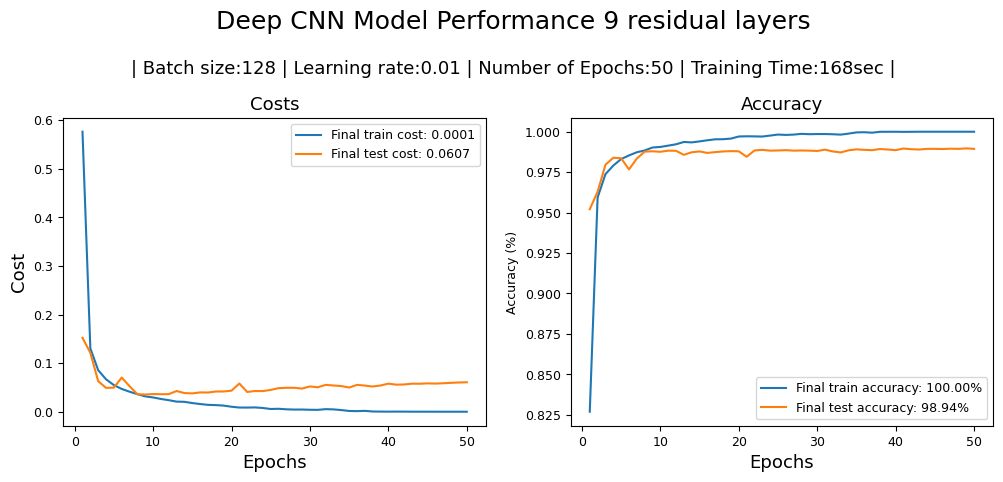

In [180]:
training_curve_plot("Deep CNN Model Performance 9 residual layers", training_loss_5, test_loss_5, training_accuracy_5, test_accuracy_5, 
batch_size_5, learning_rate_5, total_time, num_epochs_5)

### 5b deep neural network no residuals

In [183]:
#make the CNN residual network for exercise 5 according to the specifications in the assignment

#resdiual architecture for the 8 channels to 8 channels
class FirstKernelResidual5b(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #mimicks the first convolution but here we will just go from 8 inputs to 8 outputs
        self.conv = torch.nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #here are the relu and pooling layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        #modeling the books residual connection from section 11.2 figure 11.5b 
        # pass it through ReLU
        x = self.relu(x)
        #then we pass it through our convolutional layer where we relu then pool
        x = self.conv(x)
        return x

#residual architecture for the 16 channels to 16 channels
class SecondKernelResidual5b(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #mimicks the first convolution but here we will just go from 8 inputs to 8 outputs
        self.conv = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        #here are the relu and pooling layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        #modeling the books residual connection from section 11.2 figure 11.5b 
        #pass through relu
        temp = self.relu(x)
        #then we pass it through our convolutional layer where we relu then pool
        x = self.conv(x)
        return x

#residual connections for 32 channels to 32 channels
class ThirdKernelResidual5b(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #mimicks the first convolution but here we will just go from 8 inputs to 8 outputs
        self.conv = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #here are the relu and pooling layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        #modeling the books residual connection from section 11.2 figure 11.5b 
        #we pass it through ReLU
        x = self.relu(x)
        #then we pass it through our convolutional layer where we relu then pool
        x = self.conv(x)
        return x


class Exercise5bCNN(torch.nn.Module):
    def __init__(self, first = 3,second = 3, third = 3):
        super().__init__()
        #1 input channel, 8 output channels, kernel size 3, stride 1, padding 1
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #adding many residual layers in this case default 3 more convolutions
        self.layer1 = torch.nn.ModuleList([FirstKernelResidual5b() for _ in range(first)])
        #first pooling layer with kernel size 2, stride 2 reduces image to (8,14,14)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        #8 input channels, 16 output channels, kernel size 3, stride 1 padding 1
        self.conv2 = torch.nn.Conv2d(in_channels= 8,out_channels= 16 , kernel_size= 3, stride= 1, padding= 1)
        #adding many residual layers in this case default 3 more convolutions at the 16 channel length
        self.layer2 = torch.nn.ModuleList([SecondKernelResidual5b() for _ in range(second)])
        #second pooling layer with kernel size 2, stride 2 reduces image to (16,7,7)
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 16 inputs, 32 outputs, kernel size 3, stride 1, padding 1
        self.conv3 = torch.nn.Conv2d(in_channels= 16,out_channels= 32 , kernel_size= 3, stride= 1, padding= 1)
        #adding many residual layers in this case default 3 more convolutions at the 32 channel length
        self.layer3 = torch.nn.ModuleList([ThirdKernelResidual5b() for _ in range(third)])
        #non linearity
        self.relu3 = torch.nn.ReLU()
        #output netwrok we have 32 channels and an image that is (7,7)
        self.output = torch.nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        #pass through the first convolution
        #we don't need to relu because we pass it through several residual layers that will handel that
        x = self.conv1(x)
        #pass through several residual layers
        for l in self.layer1:
            x = l(x)
        #pooling at the end of residual connections because pool will decrease our image size
        x = self.pool1(x)
        #pass through the second convolution to get to the next channel size of 16 and smaller image 
        x = self.conv2(x)
        #pass through several residual layers
        for l in self.layer2:
            x = l(x)
        #pooling to reduce size for the third convolutional layer
        x = self.pool2(x)
        #pass through the final convolution
        x = self.conv3(x)
        #pass through more residual convolutions then
        for l in self.layer3:
            x = l(x)
        #final relu
        x = self.relu3(x)
        #flatten all dimensions except batch dimension which is dimension 0 so we start at 1
        x = torch.flatten(x, 1)
        #pass through our output layer
        x = self.output(x)
        return x

#want to set some hyperparameters 
learning_rate_5b = 0.01
batch_size_5b = 128
num_epochs_5b = 50

#Make the CNN neural netowrk model
model_5b = Exercise5bCNN().to(device)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_5b = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations since we will change this later
optimizer_5b = torch.optim.SGD(model_5b.parameters(), lr= learning_rate_5b)

#find the start time
start_5b = time.time()

#run the training loop
training_loss_5b, training_accuracy_5b, test_loss_5b, test_accuracy_5b = training_loop(train_loader_cnn, test_loader_cnn, 
num_epochs_5b, model_5b, loss_5b, optimizer_5b)

#end time and get the total time
end_5b = time.time()
total_time = end_5b - start_5b

Starting the Training Loop
Epoch: 0 done. Test loss 2.30106782913208. Test accuracy 0.1135
Epoch: 1 done. Test loss 2.3010473251342773. Test accuracy 0.1135
Epoch: 2 done. Test loss 2.30102801322937. Test accuracy 0.1135
Epoch: 3 done. Test loss 2.301013708114624. Test accuracy 0.1135
Epoch: 4 done. Test loss 2.3010058403015137. Test accuracy 0.1135
Epoch: 5 done. Test loss 2.301048755645752. Test accuracy 0.1135
Epoch: 6 done. Test loss 2.3010690212249756. Test accuracy 0.1135
Epoch: 7 done. Test loss 2.3010334968566895. Test accuracy 0.1135
Epoch: 8 done. Test loss 2.300999879837036. Test accuracy 0.1135
Epoch: 9 done. Test loss 2.301024913787842. Test accuracy 0.1135
Epoch: 10 done. Test loss 2.301023244857788. Test accuracy 0.1135
Epoch: 11 done. Test loss 2.301022529602051. Test accuracy 0.1135
Epoch: 12 done. Test loss 2.301038980484009. Test accuracy 0.1135
Epoch: 13 done. Test loss 2.3010365962982178. Test accuracy 0.1135
Epoch: 14 done. Test loss 2.3010170459747314. Test accur

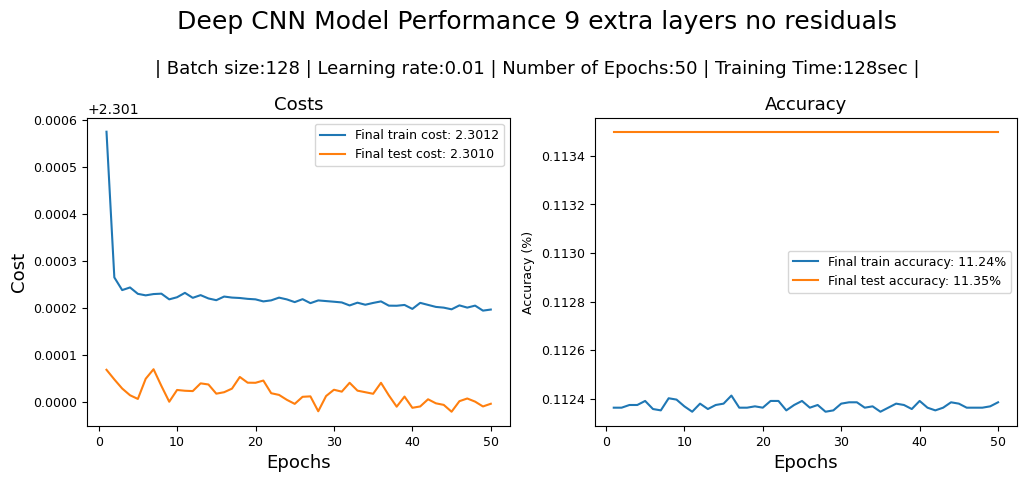

In [184]:
training_curve_plot("Deep CNN Model Performance 9 extra layers no residuals", training_loss_5b, test_loss_5b, training_accuracy_5b, test_accuracy_5b, 
batch_size_5b, learning_rate_5b, total_time, num_epochs_5b)

## Exercise 6a
#### Adding batch normalization to residual layers

In [ ]:
#make the CNN residual network for exercise 6 with batch normalization added which is a regularization technique

#resdiual architecture for the 8 channels to 8 channels
class FirstKernelResidual6a(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #mimicks the first convolution but here we will just go from 8 inputs to 8 outputs
        self.conv = torch.nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #also want to batch normalize the input
        #takes input (N,C,H,W) where C is channels I think so in this case 8
        self.norm = torch.nn.BatchNorm2d(8)
        #here are the relu and pooling layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        #modeling the books residual connection from section 11.2 figure 11.5b and 11.6 for batch normalization
        #first we batch normalize
        temp = self.norm(x)
        #then we pass it through ReLU
        temp = self.relu(temp)
        #then we pass it through our convolutional layer where we relu then pool
        temp = self.conv(temp)
        #add in our residual connection
        x = x + temp
        return x

#residual architecture for the 16 channels to 16 channels
class SecondKernelResidual6a(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #mimicks the first convolution but here we will just go from 8 inputs to 8 outputs
        self.conv = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        #also want to batch normalize the input
        #takes input (N,C,H,W) where C is channels I think so in this case 8
        self.norm = torch.nn.BatchNorm2d(16)
        #here are the relu and pooling layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        #modeling the books residual connection from section 11.2 figure 11.5b 
        #first we batch normalize
        temp = self.norm(x)
        #then we pass it through ReLU
        temp = self.relu(temp)
        #then we pass it through our convolutional layer where we relu then pool
        temp = self.conv(temp)
        #add in our residual connection
        x = x + temp
        return x

#residual connections for 32 channels to 32 channels
class ThirdKernelResidual6a(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #mimicks the first convolution but here we will just go from 8 inputs to 8 outputs
        self.conv = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #also want to batch normalize the input
        #takes input (N,C,H,W) where C is channels I think so in this case 8
        self.norm = torch.nn.BatchNorm2d(32)
        #here are the relu and pooling layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        #modeling the books residual connection from section 11.2 figure 11.5b 
        #first we batch normalize
        temp = self.norm(x)
        #then we pass it through ReLU
        temp = self.relu(temp)
        #then we pass it through our convolutional layer where we relu then pool
        temp = self.conv(temp)
        #add in our residual connection
        x = x + temp
        return x


class Exercise6aCNN(torch.nn.Module):
    def __init__(self, first = 3,second = 3, third = 3):
        super().__init__()
        #1 input channel, 8 output channels, kernel size 3, stride 1, padding 1
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        #adding many residual layers in this case default 3 more convolutions
        self.layer1 = torch.nn.ModuleList([FirstKernelResidual6a() for _ in range(first)])
        #first pooling layer with kernel size 2, stride 2 reduces image to (8,14,14)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        #8 input channels, 16 output channels, kernel size 3, stride 1 padding 1
        self.conv2 = torch.nn.Conv2d(in_channels= 8,out_channels= 16 , kernel_size= 3, stride= 1, padding= 1)
        #adding many residual layers in this case default 3 more convolutions at the 16 channel length
        self.layer2 = torch.nn.ModuleList([SecondKernelResidual6a() for _ in range(second)])
        #second pooling layer with kernel size 2, stride 2 reduces image to (16,7,7)
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 16 inputs, 32 outputs, kernel size 3, stride 1, padding 1
        self.conv3 = torch.nn.Conv2d(in_channels= 16,out_channels= 32 , kernel_size= 3, stride= 1, padding= 1)
        #adding many residual layers in this case default 3 more convolutions at the 32 channel length
        self.layer3 = torch.nn.ModuleList([ThirdKernelResidual6a() for _ in range(third)])
        #non linearity
        self.relu3 = torch.nn.ReLU()
        #output netwrok we have 32 channels and an image that is (7,7)
        self.output = torch.nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        #pass through the first convolution
        #we don't need to relu because we pass it through several residual layers that will handel that
        x = self.conv1(x)
        #pass through several residual layers
        for l in self.layer1:
            x = l(x)
        #pooling at the end of residual connections because pool will decrease our image size
        x = self.pool1(x)
        #pass through the second convolution to get to the next channel size of 16 and smaller image 
        x = self.conv2(x)
        #pass through several residual layers
        for l in self.layer2:
            x = l(x)
        #pooling to reduce size for the third convolutional layer
        x = self.pool2(x)
        #pass through the final convolution
        x = self.conv3(x)
        #pass through more residual convolutions then
        for l in self.layer3:
            x = l(x)
        #final relu
        x = self.relu3(x)
        #flatten all dimensions except batch dimension which is dimension 0 so we start at 1
        x = torch.flatten(x, 1)
        #pass through our output layer
        x = self.output(x)
        return x

#want to set some hyperparameters 
learning_rate_6a = 0.001
batch_size_6a = 128
num_epochs_6a = 50

#Make the CNN neural netowrk model
model_6a = Exercise6aCNN().to(device)
#Our loss function will be cross entropy since we are getting a probability distribution
loss_6a = torch.nn.CrossEntropyLoss()
#Here we are going to use classic stochastic gradient descent without any special optimizations since we will change this later
optimizer_6a = torch.optim.Adam(model_6a.parameters(), lr= learning_rate_6a)

#find the start time
start_6a = time.time()

#run the training loop
training_loss_6a, training_accuracy_6a, test_loss_6a, test_accuracy_6a = training_loop(train_loader_cnn, test_loader_cnn, 
num_epochs_6a, model_6a, loss_6a, optimizer_6a)

#end time and get the total time
end_6a = time.time()
total_time = end_6a - start_6a